## Overview

This notebook shows how to train and deploy a machine learning model in AWS SageMaker

Based on:

https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk/pytorch_cnn_cifar10

https://jovian.ml/aakashns/05-cifar10-cnn

## Set up the environment

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10-test'

role = sagemaker.get_execution_role()

In [2]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Instance type = local


## Download the CIFAR10 dataset

In [3]:
import sys
sys.path.append('./code')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


    horse       cat      deer      deer


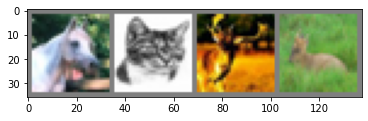

In [6]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

## Upload the dataset to S3 bucket

In [7]:
# inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

In [8]:
inputs = 's3://sagemaker-us-east-1-809378912851/data/cifar10'

## Train the model

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### Predicting Functions

* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. 

If `instance_type` is set to a SageMaker instance type (e.g. ml.p2.xlarge) then the training will happen on SageMaker.

If training on SageMaker then it needs to reference the training data on S3.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. 

In [9]:
from sagemaker.pytorch import PyTorch

cifar10_estimator = PyTorch(entry_point='code/train.py',
                            role=role,
                            framework_version='1.4.0',
                            train_instance_count=1,
                            train_instance_type='ml.m4.xlarge')

cifar10_estimator.fit(inputs)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-14 08:20:48 Starting - Starting the training job...
2020-09-14 08:20:50 Starting - Launching requested ML instances.........
2020-09-14 08:22:24 Starting - Preparing the instances for training.........
2020-09-14 08:23:59 Downloading - Downloading input data.............................................
2020-09-14 08:31:45 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-09-14 08:31:46,877 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-09-14 08:31:46,880 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-14 08:31:46,893 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-09-14 08:31:47,515 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-09-14 08:31:47,987 sagemaker-containers INFO     Module def

## Deploy the trained model

First we need to create a `PyTorchModel` object from the estimator. The `deploy()` method on the model object creates an endpoint (in this case locally) which serves prediction requests in real-time. If the `instance_type` is set to a SageMaker instance type (e.g. ml.m4.xlarge) then the model will be deployed on SageMaker. 

In [10]:
%%time
from sagemaker.pytorch import PyTorchModel

cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1,
                                             instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!CPU times: user 397 ms, sys: 18.5 ms, total: 416 ms
Wall time: 8min 33s


## Invoke end-point

GroundTruth:   cat ship ship plane
Predicted:   dog plane ship plane


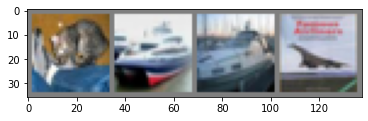

In [11]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

## Clean-up

In [12]:
cifar10_estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.
